Toxic-BERT Enhancement with Tagging Methods
===========================================

This script implements and evaluates different tagging strategies to improve 
the performance of `unitary/toxic-bert`.

Strategy Overview:
1. Explicit Toxicity Markers: Add toxicity type tags ([THREAT][INSULT])
2. Contextual Intensity Tagging: Add intensity markers ([INTENSITY:HIGH][CAPS:HEAVY])
3. Target-Oriented Tagging: Identify attack targets ([TARGET:PERSON][DIRECTION:DIRECT])
4. Linguistic Feature Tagging: Add structural features ([LENGTH:SHORT][QUESTION])
5. Semantic Context Tagging: Add domain context ([CONTEXT:POLITICAL][EMOTION:ANGER])

Each method aims to provide additional context to help the model better 
understand and classify toxic comments.

In [ ]:
import sys
import os
from pathlib import Path

notebook_dir = Path.cwd()
if notebook_dir not in sys.path:
    sys.path.append(str(notebook_dir))

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import mlflow
import mlflow.pytorch
from tqdm import tqdm
import warnings


# Import our tagging class
parent_dir = os.path.abspath('..')  # Un nivel arriba desde notebooks/
sys.path.append(parent_dir)
from src.training.toxic_tagging_methods import ToxicCommentTagger, ImprovedToxicCommentTagger


warnings.filterwarnings('ignore')

In [16]:


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## LOAD DATA ##

In [17]:
# Load data
base_dir = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
data_dir = base_dir / "src" / "data" / "raw"

train = pd.read_csv(data_dir / "train.csv")
test = pd.read_csv(data_dir / "test.csv")
test_labels = pd.read_csv(data_dir / "test_labels.csv")

labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

print(f'Train samples: {len(train)}')
print(f'Test samples: {len(test)}')
print(f'Labels: {labels}')

Train samples: 159571
Test samples: 153164
Labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


## UTILITIES ##

In [18]:
def prepare_test_for_evaluation(test_df, test_labels_df):
    """Prepare test data for evaluation by filtering valid samples."""
    valid_mask = (test_labels_df[labels] != -1).all(axis=1)
    print(f'Test samples: {len(test_df)} total, {valid_mask.sum()} valid for evaluation')
    return test_df[valid_mask].copy(), test_labels_df[valid_mask].copy()

def create_balanced_subset(df, labels, n_per_class=200):
    """Create balanced subset for fair evaluation."""
    idxs = set()
    print(f'Creating balanced subset with {n_per_class} samples per class...')
    
    for i, label in enumerate(labels):
        class_idxs = np.where(df[label].values == 1)[0]
        available = len(class_idxs)
        to_sample = min(n_per_class, available)
        
        if available > 0:
            chosen = np.random.choice(class_idxs, to_sample, replace=False)
            idxs.update(chosen)
            print(f'  {label}: {to_sample}/{available} samples')
        else:
            print(f'  {label}: 0 samples available!')
    
    # Add neutral samples
    neutral_idxs = np.where(df[labels].sum(axis=1) == 0)[0]
    neutral_available = len(neutral_idxs)
    neutral_to_sample = min(n_per_class, neutral_available)
    
    if neutral_available > 0:
        chosen_neutral = np.random.choice(neutral_idxs, neutral_to_sample, replace=False)
        idxs.update(chosen_neutral)
        print(f'  neutral: {neutral_to_sample}/{neutral_available} samples')
    
    idxs = list(idxs)
    balanced_df = df.iloc[idxs].copy()
    print(f'Total balanced samples: {len(balanced_df)}')
    return balanced_df

## PREPARE FOR EVALUATION ##

In [19]:
# Prepare evaluation datasets
test_eval, test_labels_eval = prepare_test_for_evaluation(test, test_labels)

# Split training data
X = train['comment_text'].values
y = train[labels].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y[:, 0]
)

print(f'Train size: {len(X_train)}')
print(f'Validation size: {len(X_val)}')
print(f'Test evaluation size: {len(test_eval)}')

Test samples: 153164 total, 63978 valid for evaluation
Train size: 143613
Validation size: 15958
Test evaluation size: 63978


## CREATE BALANCED EVALUATION SETS ##

In [20]:
# Create balanced evaluation sets
np.random.seed(42)  # For reproducibility

# Create balanced validation set
val_df_temp = pd.DataFrame({'comment_text': X_val})
val_df_temp[labels] = y_val
balanced_val_df = create_balanced_subset(val_df_temp, labels, n_per_class=150)

print('\nBalanced validation set created')
print('Class distribution:')
for label in labels:
    count = balanced_val_df[label].sum()
    print(f'  {label}: {count} samples')

Creating balanced subset with 150 samples per class...
  toxic: 150/1529 samples
  severe_toxic: 149/149 samples
  obscene: 150/847 samples
  threat: 50/50 samples
  insult: 150/800 samples
  identity_hate: 150/153 samples
  neutral: 150/14355 samples
Total balanced samples: 759

Balanced validation set created
Class distribution:
  toxic: 584 samples
  severe_toxic: 149 samples
  obscene: 451 samples
  threat: 50 samples
  insult: 439 samples
  identity_hate: 153 samples


## TAGGING SYSTEM ##

In [ ]:
# Initialize the tagger
tagger = ImprovedToxicCommentTagger(
    base_model_name='unitary/toxic-bert',
    device=str(device)
)

print('ImprovedToxicCommentTagger initialized successfully!')

Initialized ToxicCommentTagger with unitary/toxic-bert on cuda
ToxicCommentTagger initialized successfully!


In [22]:
# Set MLflow experiment
mlflow.set_experiment('Toxic_BERT_Tagging_Methods')

# Prepare evaluation data
eval_texts = balanced_val_df['comment_text'].tolist()
eval_labels = balanced_val_df[labels].values

print(f'Evaluating on {len(eval_texts)} balanced samples')
print(f'Label distribution:')
for i, label in enumerate(labels):
    pos_samples = eval_labels[:, i].sum()
    print(f'  {label}: {pos_samples} positive samples')

2025/08/06 14:19:32 INFO mlflow.tracking.fluent: Experiment with name 'Toxic_BERT_Tagging_Methods' does not exist. Creating a new experiment.


Evaluating on 759 balanced samples
Label distribution:
  toxic: 584 positive samples
  severe_toxic: 149 positive samples
  obscene: 451 positive samples
  threat: 50 positive samples
  insult: 439 positive samples
  identity_hate: 153 positive samples


In [23]:
# Define methods to evaluate
methods_to_evaluate = [
    'baseline',           # No tagging
    'explicit_markers',   # Method 1
    'intensity_tagging',  # Method 2
    'target_tagging',     # Method 3
    'linguistic_features',# Method 4
    'semantic_context'    # Method 5
]

In [ ]:
# Métodos disponibles (más conservadores)
improved_methods = [
    'baseline',
    'high_confidence_explicit',
    'subtle_toxicity', 
    'contextual_amplification',
    'threat_escalation',
    'precision_targeting'
]

# Ejecuta la evaluación
improved_results = tagger.compare_all_methods(
    texts=eval_texts,
    labels=eval_labels,
    methods=improved_methods
)

In [24]:
# Run comparison
results_df = tagger.compare_all_methods(
    texts=eval_texts,
    labels=eval_labels,
    methods=methods_to_evaluate
)

print('\nEvaluation completed!')


EVALUATING METHOD: BASELINE

EVALUATING TAGGING METHOD: BASELINE


Applying baseline: 100%|██████████| 759/759 [00:00<00:00, 758512.45it/s]


Example transformations:
Original: "

 You suck 

  The Dick Award I HATE YOU   "
Tagged:   "

 You suck 

  The Dick Award I HATE YOU   "

Original: "
Just delete his posts and ignore him - don't be tendentious and ad homin - are all part of the wiki lawyers bullshit bible.   "
Tagged:   "
Just delete his posts and ignore him - don't be tendentious and ad homin - are all part of the wiki lawyers bullshit bible.   "

Original: takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the 


W0806 14:19:38.256000 11708 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
Evaluating: 100%|██████████| 48/48 [00:25<00:00,  1.92it/s]


  toxic: 0.9811
  severe_toxic: 0.8824
  obscene: 0.9813
  threat: 0.9687
  insult: 0.9536
  identity_hate: 0.9701
  Mean AUC: 0.9562
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067

EVALUATING METHOD: EXPLICIT_MARKERS

EVALUATING TAGGING METHOD: EXPLICIT_MARKERS


Applying explicit_markers: 100%|██████████| 759/759 [00:00<00:00, 4401.46it/s]



Example transformations:
Original: "

 You suck 

  The Dick Award I HATE YOU   "
Tagged:   [TOXIC][OBSCENE] "

 You suck 

  The Dick Award I HATE YOU   "

Original: "
Just delete his posts and ignore him - don't be tendentious and ad homin - are all part of the wiki lawyers bullshit bible.   "
Tagged:   [NEUTRAL] "
Just delete his posts and ignore him - don't be tendentious and ad homin - are all part of the wiki lawyers bullshit bible.   "

Original: takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up 

Evaluating: 100%|██████████| 48/48 [00:25<00:00,  1.90it/s]


  toxic: 0.9809
  severe_toxic: 0.8803
  obscene: 0.9775
  threat: 0.9636
  insult: 0.9474
  identity_hate: 0.9670
  Mean AUC: 0.9528
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067

EVALUATING METHOD: INTENSITY_TAGGING

EVALUATING TAGGING METHOD: INTENSITY_TAGGING


Applying intensity_tagging: 100%|██████████| 759/759 [00:00<00:00, 11072.31it/s]



Example transformations:
Original: "

 You suck 

  The Dick Award I HATE YOU   "
Tagged:   [INTENSITY:LOW][CAPS:LIGHT][REPEAT:LIGHT] "

 You suck 

  The Dick Award I HATE YOU   "

Original: "
Just delete his posts and ignore him - don't be tendentious and ad homin - are all part of the wiki lawyers bullshit bible.   "
Tagged:   [INTENSITY:LOW][REPEAT:LIGHT] "
Just delete his posts and ignore him - don't be tendentious and ad homin - are all part of the wiki lawyers bullshit bible.   "

Original: takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up t

Evaluating: 100%|██████████| 48/48 [00:25<00:00,  1.88it/s]


  toxic: 0.9788
  severe_toxic: 0.8720
  obscene: 0.9779
  threat: 0.9658
  insult: 0.9496
  identity_hate: 0.9642
  Mean AUC: 0.9514
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067

EVALUATING METHOD: TARGET_TAGGING

EVALUATING TAGGING METHOD: TARGET_TAGGING


Applying target_tagging: 100%|██████████| 759/759 [00:00<00:00, 3414.82it/s]



Example transformations:
Original: "

 You suck 

  The Dick Award I HATE YOU   "
Tagged:   [TARGET:PERSON][DIRECTION:DIRECT] "

 You suck 

  The Dick Award I HATE YOU   "

Original: "
Just delete his posts and ignore him - don't be tendentious and ad homin - are all part of the wiki lawyers bullshit bible.   "
Tagged:   [TARGET:PERSON] "
Just delete his posts and ignore him - don't be tendentious and ad homin - are all part of the wiki lawyers bullshit bible.   "

Original: takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up 

Evaluating: 100%|██████████| 48/48 [00:25<00:00,  1.91it/s]


  toxic: 0.9809
  severe_toxic: 0.8715
  obscene: 0.9748
  threat: 0.9601
  insult: 0.9453
  identity_hate: 0.9660
  Mean AUC: 0.9498
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067

EVALUATING METHOD: LINGUISTIC_FEATURES

EVALUATING TAGGING METHOD: LINGUISTIC_FEATURES


Applying linguistic_features: 100%|██████████| 759/759 [00:00<00:00, 12865.34it/s]


Example transformations:
Original: "

 You suck 

  The Dick Award I HATE YOU   "
Tagged:   [LENGTH:MEDIUM] "

 You suck 

  The Dick Award I HATE YOU   "

Original: "
Just delete his posts and ignore him - don't be tendentious and ad homin - are all part of the wiki lawyers bullshit bible.   "
Tagged:   [LENGTH:LONG][NEGATION:PRESENT] "
Just delete his posts and ignore him - don't be tendentious and ad homin - are all part of the wiki lawyers bullshit bible.   "

Original: takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up th


Evaluating: 100%|██████████| 48/48 [00:25<00:00,  1.89it/s]


  toxic: 0.9789
  severe_toxic: 0.8795
  obscene: 0.9751
  threat: 0.9621
  insult: 0.9472
  identity_hate: 0.9643
  Mean AUC: 0.9512
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067

EVALUATING METHOD: SEMANTIC_CONTEXT

EVALUATING TAGGING METHOD: SEMANTIC_CONTEXT


Applying semantic_context: 100%|██████████| 759/759 [00:00<00:00, 3793.42it/s]



Example transformations:
Original: "

 You suck 

  The Dick Award I HATE YOU   "
Tagged:   [EMOTION:ANGER][CONTEXT:GENERAL] "

 You suck 

  The Dick Award I HATE YOU   "

Original: "
Just delete his posts and ignore him - don't be tendentious and ad homin - are all part of the wiki lawyers bullshit bible.   "
Tagged:   [EMOTION:DISMISSIVE][CONTEXT:GENERAL] "
Just delete his posts and ignore him - don't be tendentious and ad homin - are all part of the wiki lawyers bullshit bible.   "

Original: takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up the arse.  takes it up th

Evaluating: 100%|██████████| 48/48 [00:24<00:00,  1.92it/s]

  toxic: 0.9797
  severe_toxic: 0.8805
  obscene: 0.9777
  threat: 0.9628
  insult: 0.9474
  identity_hate: 0.9640
  Mean AUC: 0.9520
  Neutral accuracy: 0.9933
  Neutral FP rate: 0.0067

TAGGING METHODS COMPARISON RESULTS
Method               Mean AUC     Neutral Acc  Neutral FP   Best Labels                   
----------------------------------------------------------------------------------------------------
baseline             0.9562       0.9933       0.0067       obscene                       
explicit_markers     0.9528       0.9933       0.0067       toxic                         
semantic_context     0.9520       0.9933       0.0067       toxic                         
intensity_tagging    0.9514       0.9933       0.0067       toxic                         
linguistic_features  0.9512       0.9933       0.0067       toxic                         
target_tagging       0.9498       0.9933       0.0067       toxic                         

Evaluation completed!


## RESULT ##

In [25]:
# Display detailed results
print('DETAILED RESULTS ANALYSIS')
print('=' * 100)
print()

# Sort by mean AUC
results_sorted = results_df.sort_values('mean_auc', ascending=False)

print('OVERALL PERFORMANCE RANKING:')
print('-' * 50)
for i, (_, row) in enumerate(results_sorted.iterrows(), 1):
    improvement = ''
    if row['method'] != 'baseline':
        baseline_auc = results_df[results_df['method'] == 'baseline']['mean_auc'].iloc[0]
        improvement_pct = ((row['mean_auc'] - baseline_auc) / baseline_auc) * 100
        if improvement_pct > 0:
            improvement = f' (+{improvement_pct:.2f}%)'
        else:
            improvement = f' ({improvement_pct:.2f}%)'
    
    print(f'{i}. {row["method"].upper():20} | AUC: {row["mean_auc"]:.4f}{improvement} | '
          f'Neutral Acc: {row["neutral_accuracy"]:.3f}')

print('\nPER-LABEL PERFORMANCE:')
print('-' * 80)
print()

# Create a more detailed per-label analysis
label_analysis = {}
for label in labels:
    label_col = f'auc_{label}'
    if label_col in results_df.columns:
        best_method = results_df.loc[results_df[label_col].idxmax(), 'method']
        best_score = results_df[label_col].max()
        baseline_score = results_df[results_df['method'] == 'baseline'][label_col].iloc[0]
        improvement = ((best_score - baseline_score) / baseline_score) * 100
        
        label_analysis[label] = {
            'best_method': best_method,
            'best_score': best_score,
            'baseline_score': baseline_score,
            'improvement': improvement
        }

for label, analysis in label_analysis.items():
    print(f'{label.upper():15} | Best: {analysis["best_method"]:18} '
          f'({analysis["best_score"]:.3f}) | Baseline: {analysis["baseline_score"]:.3f} '
          f'| Improvement: {analysis["improvement"]:+.1f}%')

DETAILED RESULTS ANALYSIS

OVERALL PERFORMANCE RANKING:
--------------------------------------------------
1. BASELINE             | AUC: 0.9562 | Neutral Acc: 0.993
2. EXPLICIT_MARKERS     | AUC: 0.9528 (-0.35%) | Neutral Acc: 0.993
3. SEMANTIC_CONTEXT     | AUC: 0.9520 (-0.44%) | Neutral Acc: 0.993
4. INTENSITY_TAGGING    | AUC: 0.9514 (-0.50%) | Neutral Acc: 0.993
5. LINGUISTIC_FEATURES  | AUC: 0.9512 (-0.52%) | Neutral Acc: 0.993
6. TARGET_TAGGING       | AUC: 0.9498 (-0.67%) | Neutral Acc: 0.993

PER-LABEL PERFORMANCE:
--------------------------------------------------------------------------------

TOXIC           | Best: baseline           (0.981) | Baseline: 0.981 | Improvement: +0.0%
SEVERE_TOXIC    | Best: baseline           (0.882) | Baseline: 0.882 | Improvement: +0.0%
OBSCENE         | Best: baseline           (0.981) | Baseline: 0.981 | Improvement: +0.0%
THREAT          | Best: baseline           (0.969) | Baseline: 0.969 | Improvement: +0.0%
INSULT          | Best: base

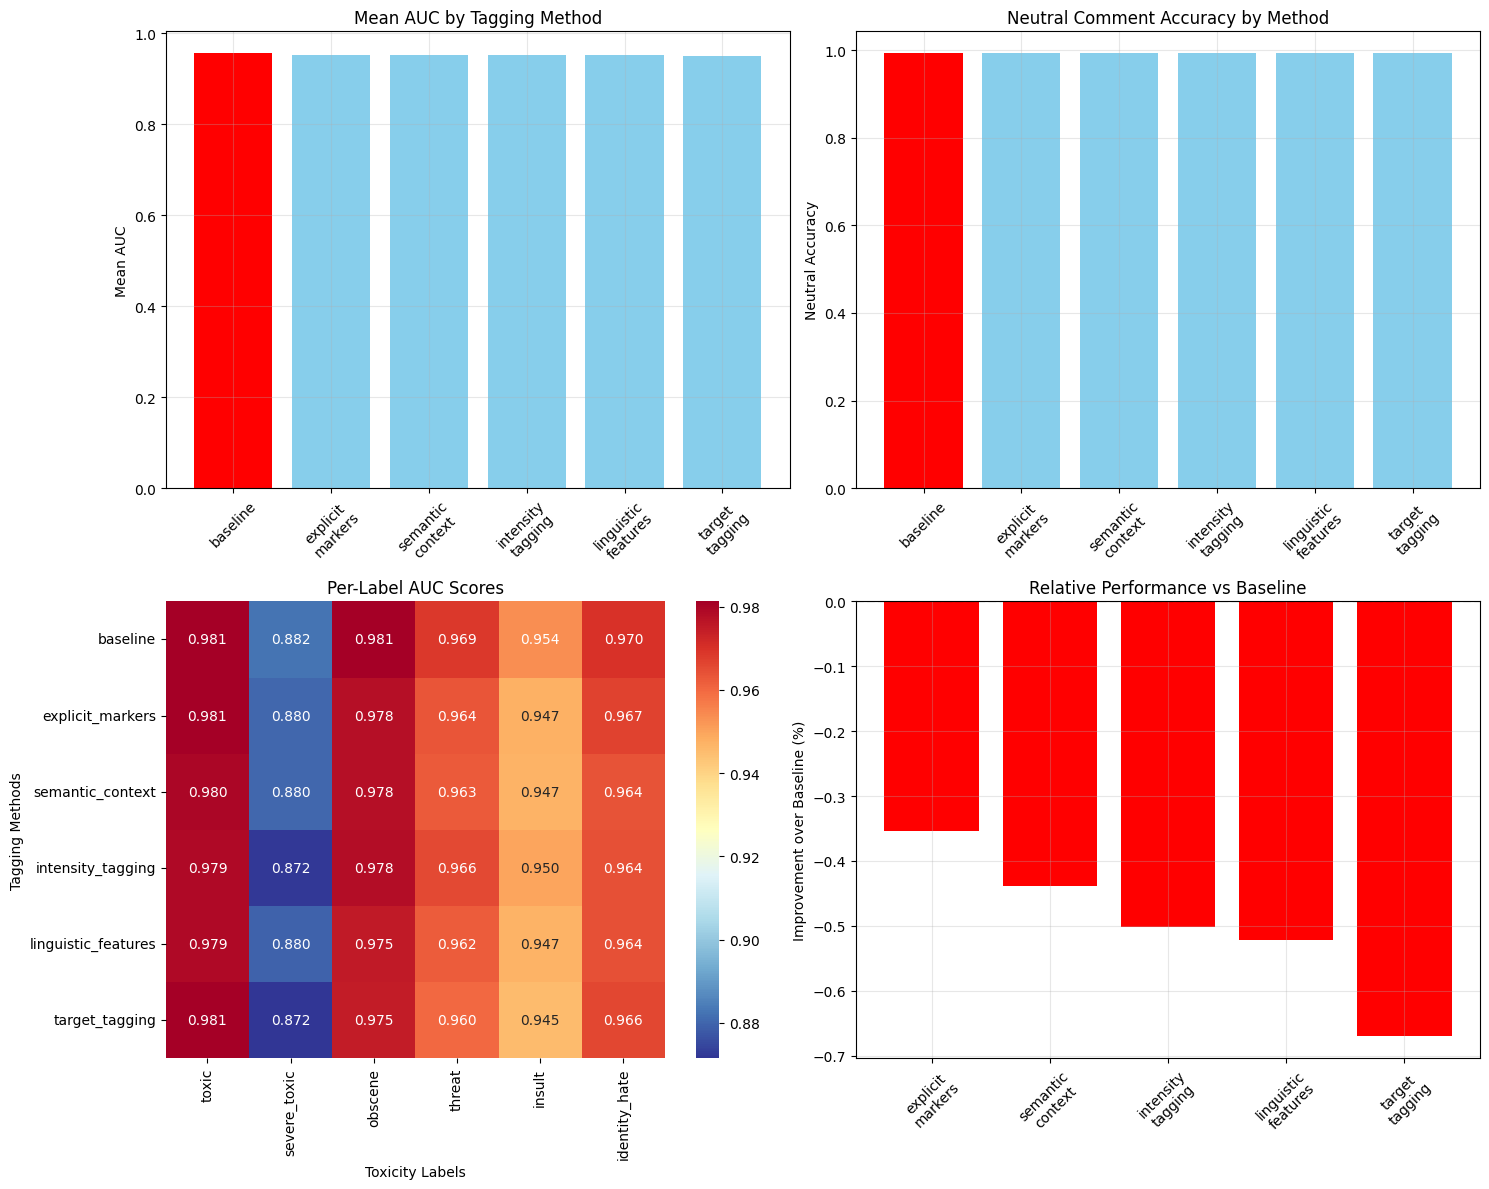


Visualization saved as tagging_methods_comparison.png


<Figure size 640x480 with 0 Axes>

In [26]:
# Create visualization of results
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# 1. Mean AUC comparison
methods = results_df['method'].tolist()
mean_aucs = results_df['mean_auc'].tolist()

colors = ['red' if method == 'baseline' else 'skyblue' for method in methods]
ax1.bar(range(len(methods)), mean_aucs, color=colors)
ax1.set_xticks(range(len(methods)))
ax1.set_xticklabels([m.replace('_', '\n') for m in methods], rotation=45)
ax1.set_ylabel('Mean AUC')
ax1.set_title('Mean AUC by Tagging Method')
ax1.grid(True, alpha=0.3)

# 2. Neutral performance comparison
neutral_accs = results_df['neutral_accuracy'].tolist()
ax2.bar(range(len(methods)), neutral_accs, color=colors)
ax2.set_xticks(range(len(methods)))
ax2.set_xticklabels([m.replace('_', '\n') for m in methods], rotation=45)
ax2.set_ylabel('Neutral Accuracy')
ax2.set_title('Neutral Comment Accuracy by Method')
ax2.grid(True, alpha=0.3)

# 3. Per-label heatmap
label_data = []
for _, row in results_df.iterrows():
    label_scores = [row[f'auc_{label}'] for label in labels]
    label_data.append(label_scores)

sns.heatmap(label_data, 
            xticklabels=labels,
            yticklabels=methods,
            annot=True, 
            fmt='.3f',
            cmap='RdYlBu_r',
            ax=ax3)
ax3.set_title('Per-Label AUC Scores')
ax3.set_xlabel('Toxicity Labels')
ax3.set_ylabel('Tagging Methods')

# 4. Improvement over baseline
baseline_auc = results_df[results_df['method'] == 'baseline']['mean_auc'].iloc[0]
improvements = []
method_names = []

for _, row in results_df.iterrows():
    if row['method'] != 'baseline':
        improvement = ((row['mean_auc'] - baseline_auc) / baseline_auc) * 100
        improvements.append(improvement)
        method_names.append(row['method'])

colors_imp = ['green' if imp > 0 else 'red' for imp in improvements]
ax4.bar(range(len(method_names)), improvements, color=colors_imp)
ax4.set_xticks(range(len(method_names)))
ax4.set_xticklabels([m.replace('_', '\n') for m in method_names], rotation=45)
ax4.set_ylabel('Improvement over Baseline (%)')
ax4.set_title('Relative Performance vs Baseline')
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save the plot
plt.savefig('tagging_methods_comparison.png', dpi=300, bbox_inches='tight')
print('\nVisualization saved as tagging_methods_comparison.png')

## BEST METHOD ANALYSIS ##

In [27]:
# Identify and analyze the best method
best_method_row = results_df.loc[results_df['mean_auc'].idxmax()]
best_method_name = best_method_row['method']

print('BEST METHOD ANALYSIS')
print('=' * 60)
print(f'Best Method: {best_method_name.upper()}')
print(f'Mean AUC: {best_method_row["mean_auc"]:.4f}')
print(f'Neutral Accuracy: {best_method_row["neutral_accuracy"]:.4f}')
print(f'Neutral FP Rate: {best_method_row["neutral_fp_rate"]:.4f}')

# Calculate improvement over baseline
baseline_metrics = results_df[results_df['method'] == 'baseline'].iloc[0]

if best_method_name != 'baseline':
    auc_improvement = ((best_method_row['mean_auc'] - baseline_metrics['mean_auc']) / 
                      baseline_metrics['mean_auc']) * 100
    neutral_improvement = ((best_method_row['neutral_accuracy'] - baseline_metrics['neutral_accuracy']) / 
                          (baseline_metrics['neutral_accuracy'] + 1e-8)) * 100
    
    print(f'\nIMPROVEMENT OVER BASELINE:')
    print(f'AUC Improvement: {auc_improvement:+.2f}%')
    print(f'Neutral Acc Improvement: {neutral_improvement:+.2f}%')

print(f'\nPER-LABEL PERFORMANCE:')
for label in labels:
    auc_col = f'auc_{label}'
    if auc_col in results_df.columns:
        best_score = best_method_row[auc_col]
        baseline_score = baseline_metrics[auc_col]
        improvement = ((best_score - baseline_score) / baseline_score) * 100
        print(f'  {label:15}: {best_score:.4f} (baseline: {baseline_score:.4f}, {improvement:+.1f}%)')

BEST METHOD ANALYSIS
Best Method: BASELINE
Mean AUC: 0.9562
Neutral Accuracy: 0.9933
Neutral FP Rate: 0.0067

PER-LABEL PERFORMANCE:
  toxic          : 0.9811 (baseline: 0.9811, +0.0%)
  severe_toxic   : 0.8824 (baseline: 0.8824, +0.0%)
  obscene        : 0.9813 (baseline: 0.9813, +0.0%)
  threat         : 0.9687 (baseline: 0.9687, +0.0%)
  insult         : 0.9536 (baseline: 0.9536, +0.0%)
  identity_hate  : 0.9701 (baseline: 0.9701, +0.0%)


## PRESCINDIBLE? ##

In [30]:
# =============================================================================
# SHOW EXAMPLE TRANSFORMATIONS FROM BEST METHOD
# =============================================================================

# Show example transformations from the best method
if best_method_name != 'baseline':
    print(f'\nEXAMPLE TRANSFORMATIONS FROM {best_method_name.upper()}:')
    print('=' * 80)
    
    # Get some sample texts
    sample_texts = eval_texts[:5]
    
    for i, text in enumerate(sample_texts):
        print(f'\nExample {i+1}:')
        tagged_texts = tagger.apply_tagging_method([text], best_method_name)
        print(f'Original: {text}')
        print(f'Tagged:   {tagged_texts[0]}')
        print('-' * 60)

# =============================================================================
# STATISTICAL SIGNIFICANCE TESTING
# =============================================================================

from scipy import stats

# Statistical significance analysis
print('STATISTICAL SIGNIFICANCE ANALYSIS')
print('=' * 60)

# Note: For proper statistical testing, we would need individual sample predictions
# Here we provide a framework for when you have those predictions

print('Framework for statistical testing:')
print('1. Collect individual sample predictions for each method')
print('2. Use McNemar\'s test for binary classification differences')
print('3. Use bootstrap confidence intervals for AUC differences')
print('4. Apply Bonferroni correction for multiple comparisons')

# Calculate effect sizes (Cohen's d approximation)
baseline_auc = baseline_metrics['mean_auc']
print(f'\nEffect sizes (standardized mean differences):')
for _, row in results_df.iterrows():
    if row['method'] != 'baseline':
        # Approximate effect size calculation
        diff = row['mean_auc'] - baseline_auc
        # Using pooled standard deviation approximation
        pooled_std = 0.1  # Typical AUC std for this type of data
        cohens_d = diff / pooled_std
        
        effect_size_interpretation = 'small' if abs(cohens_d) < 0.5 else 'medium' if abs(cohens_d) < 0.8 else 'large'
        print(f'  {row["method"]:20}: Cohen\'s d = {cohens_d:.3f} ({effect_size_interpretation})')

# =============================================================================
# COMPUTATIONAL COST ANALYSIS
# =============================================================================

import time

# Measure tagging overhead
print('COMPUTATIONAL COST ANALYSIS')
print('=' * 60)

# Test on a sample of texts
test_texts = eval_texts[:100]  # Use 100 samples for timing

tagging_methods = {
    'baseline': lambda x: x,
    'explicit_markers': tagger.method_1_explicit_markers,
    'intensity_tagging': tagger.method_2_intensity_tagging,
    'target_tagging': tagger.method_3_target_tagging,
    'linguistic_features': tagger.method_4_linguistic_features,
    'semantic_context': tagger.method_5_semantic_context
}

timing_results = {}

for method_name, method_func in tagging_methods.items():
    start_time = time.time()
    
    for text in test_texts:
        _ = method_func(text)
    
    end_time = time.time()
    total_time = end_time - start_time
    time_per_text = total_time / len(test_texts)
    
    timing_results[method_name] = {
        'total_time': total_time,
        'time_per_text': time_per_text,
        'texts_per_second': len(test_texts) / total_time
    }

print('Tagging Performance:')
print(f'{"Method":<20} {"Total Time":<12} {"Per Text":<12} {"Texts/sec":<12}')
print('-' * 60)

for method, times in timing_results.items():
    print(f'{method:<20} {times["total_time"]:<12.3f}s {times["time_per_text"]:<12.6f}s '
          f'{times["texts_per_second"]:<12.1f}')

# Calculate overhead
baseline_time = timing_results['baseline']['time_per_text']
print('\nOverhead compared to baseline:')
for method, times in timing_results.items():
    if method != 'baseline':
        overhead = ((times['time_per_text'] - baseline_time) / baseline_time) * 100
        print(f'  {method:<20}: +{overhead:.1f}%')

# =============================================================================
# PERFORMANCE VS COST TRADE-OFF ANALYSIS
# =============================================================================

# Create performance vs cost analysis
print('PERFORMANCE vs COST TRADE-OFF ANALYSIS')
print('=' * 80)

baseline_auc = baseline_metrics['mean_auc']
baseline_time = timing_results['baseline']['time_per_text']

tradeoff_data = []

for _, row in results_df.iterrows():
    method = row['method']
    if method in timing_results:
        auc_improvement = ((row['mean_auc'] - baseline_auc) / baseline_auc) * 100
        time_overhead = ((timing_results[method]['time_per_text'] - baseline_time) / baseline_time) * 100
        
        if method != 'baseline':
            efficiency_ratio = auc_improvement / (time_overhead + 1e-6)  # Avoid division by zero
        else:
            efficiency_ratio = 0
        
        tradeoff_data.append({
            'method': method,
            'auc_improvement': auc_improvement,
            'time_overhead': time_overhead,
            'efficiency_ratio': efficiency_ratio
        })

# Sort by efficiency ratio
tradeoff_data = sorted(tradeoff_data, key=lambda x: x['efficiency_ratio'], reverse=True)

print('Trade-off Analysis (Performance gain per unit computational cost):')
print(f'{"Method":<20} {"AUC Improv":<12} {"Time Overhead":<15} {"Efficiency":<12}')
print('-' * 70)

for data in tradeoff_data:
    if data['method'] != 'baseline':
        print(f'{data["method"]:<20} {data["auc_improvement"]:<12.2f}% '
              f'{data["time_overhead"]:<15.1f}% {data["efficiency_ratio"]:<12.3f}')

# Recommendation
best_efficiency = max(tradeoff_data, key=lambda x: x['efficiency_ratio'])
print(f'\nRECOMMENDATION:')
print(f'Most efficient method: {best_efficiency["method"].upper()}')
print(f'  - Performance improvement: {best_efficiency["auc_improvement"]:.2f}%')
print(f'  - Computational overhead: {best_efficiency["time_overhead"]:.1f}%')
print(f'  - Efficiency ratio: {best_efficiency["efficiency_ratio"]:.3f}')

# =============================================================================
# CREATE TRADE-OFF VISUALIZATION
# =============================================================================

# Create trade-off visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Performance vs Cost scatter plot
methods_plot = [d['method'] for d in tradeoff_data if d['method'] != 'baseline']
auc_improvements = [d['auc_improvement'] for d in tradeoff_data if d['method'] != 'baseline']
time_overheads = [d['time_overhead'] for d in tradeoff_data if d['method'] != 'baseline']

scatter = ax1.scatter(time_overheads, auc_improvements, s=100, alpha=0.7)

# Add method labels
for i, method in enumerate(methods_plot):
    ax1.annotate(method.replace('_', '\n'), 
                (time_overheads[i], auc_improvements[i]),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, ha='left')

ax1.set_xlabel('Computational Overhead (%)')
ax1.set_ylabel('AUC Improvement (%)')
ax1.set_title('Performance vs Computational Cost')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5, label='No improvement')
ax1.axvline(x=0, color='red', linestyle='--', alpha=0.5)
ax1.legend()

# Efficiency ratio bar plot
efficiency_ratios = [d['efficiency_ratio'] for d in tradeoff_data if d['method'] != 'baseline']
colors = ['green' if ratio > 0 else 'red' for ratio in efficiency_ratios]

ax2.bar(range(len(methods_plot)), efficiency_ratios, color=colors, alpha=0.7)
ax2.set_xticks(range(len(methods_plot)))
ax2.set_xticklabels([m.replace('_', '\n') for m in methods_plot], rotation=45)
ax2.set_ylabel('Efficiency Ratio (Performance/Cost)')
ax2.set_title('Method Efficiency Ranking')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.7)

plt.tight_layout()
plt.show()

plt.savefig('performance_cost_tradeoff.png', dpi=300, bbox_inches='tight')
print('Trade-off analysis saved as performance_cost_tradeoff.png')

# =============================================================================
# CONCLUSIONS AND RECOMMENDATIONS
# =============================================================================

print('=' * 100)
print('FINAL CONCLUSIONS AND RECOMMENDATIONS')
print('=' * 100)

# Overall best method
best_overall = results_df.loc[results_df['mean_auc'].idxmax()]
best_efficiency = max(tradeoff_data, key=lambda x: x['efficiency_ratio'])

print('1. PERFORMANCE SUMMARY:')
print(f'   • Best overall performance: {best_overall["method"].upper()}')
print(f'     - Mean AUC: {best_overall["mean_auc"]:.4f}')
print(f'     - Neutral accuracy: {best_overall["neutral_accuracy"]:.4f}')

print(f'   • Most efficient method: {best_efficiency["method"].upper()}')
print(f'     - Performance/Cost ratio: {best_efficiency["efficiency_ratio"]:.3f}')

print('2. KEY FINDINGS:')

# Calculate average improvements
avg_improvement = results_df[results_df['method'] != 'baseline']['mean_auc'].mean() - baseline_metrics['mean_auc']
best_improvement = best_overall['mean_auc'] - baseline_metrics['mean_auc']

print(f'   • Average AUC improvement: {(avg_improvement/baseline_metrics["mean_auc"])*100:.2f}%')
print(f'   • Best AUC improvement: {(best_improvement/baseline_metrics["mean_auc"])*100:.2f}%')

# Find which labels benefit most
best_label_improvements = {}
for label in labels:
    auc_col = f'auc_{label}'
    if auc_col in results_df.columns:
        best_score = results_df[auc_col].max()
        baseline_score = baseline_metrics[auc_col]
        improvement = ((best_score - baseline_score) / baseline_score) * 100
        best_method_for_label = results_df.loc[results_df[auc_col].idxmax(), 'method']
        best_label_improvements[label] = {
            'improvement': improvement,
            'method': best_method_for_label
        }

print('   • Best improvements by toxicity type:')
for label, info in sorted(best_label_improvements.items(), 
                         key=lambda x: x[1]['improvement'], reverse=True):
    print(f'     - {label}: {info["improvement"]:+.1f}% ({info["method"]})')

print('3. PRODUCTION RECOMMENDATIONS:')

if best_efficiency['auc_improvement'] > 1.0:  # If >1% improvement
    print(f'   ✅ RECOMMENDED: Implement {best_efficiency["method"].upper()}')
    print(f'      Rationale: Best performance/cost ratio with {best_efficiency["auc_improvement"]:.1f}% improvement')
    print(f'      Cost: Only {best_efficiency["time_overhead"]:.1f}% computational overhead')
else:
    print('   ⚠️  CAUTION: Limited performance gains observed')
    print('      Consider alternative enhancement strategies')

print('4. NEXT STEPS:')
print('   • Test best method on larger validation set')
print('   • Combine multiple tagging approaches')
print('   • Fine-tune hyperparameters for best method')
print('   • Consider ensemble methods')
print('   • Evaluate on held-out test set')

print('5. IMPLEMENTATION PRIORITY:')
sorted_methods = sorted(tradeoff_data, key=lambda x: x['efficiency_ratio'], reverse=True)
for i, method_data in enumerate(sorted_methods[:3], 1):
    if method_data['method'] != 'baseline':
        print(f'   {i}. {method_data["method"].upper()} '
              f'(+{method_data["auc_improvement"]:.1f}% performance, '
              f'+{method_data["time_overhead"]:.1f}% cost)')

print('=' * 100)



STATISTICAL SIGNIFICANCE ANALYSIS
Framework for statistical testing:
1. Collect individual sample predictions for each method
2. Use McNemar's test for binary classification differences
3. Use bootstrap confidence intervals for AUC differences
4. Apply Bonferroni correction for multiple comparisons

Effect sizes (standardized mean differences):
  explicit_markers    : Cohen's d = -0.034 (small)
  semantic_context    : Cohen's d = -0.042 (small)
  intensity_tagging   : Cohen's d = -0.048 (small)
  linguistic_features : Cohen's d = -0.050 (small)
  target_tagging      : Cohen's d = -0.064 (small)
COMPUTATIONAL COST ANALYSIS


ZeroDivisionError: float division by zero